In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%%capture
!pip install fastai --upgrade
!pip install rasterio
!pip install --upgrade albumentations

In [ ]:
import torch
print(torch.__version__)
print(torch.cuda.is_available())

import fastai
print(fastai.__version__)

# other imports
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image

from fastai.vision.all import *
import rasterio as rio

1.7.0+cu101
True
2.1.8


In [ ]:
path = Path('drive/My Drive/landcovernet_final')
path_img = path/'inputs'
path_lbl = path/'targets'

In [ ]:
fnames = get_image_files(path_img)
def get_y_fn(x) :
  return path_lbl/f'{re.findall(r"(.*2018)[0-9]+_RGB", x.stem)[0]}_LC_10m.png'

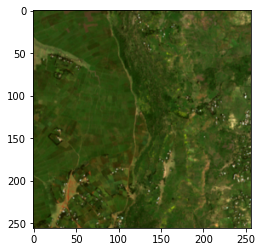

In [ ]:
plt.imshow(plt.imread(fnames[59]))

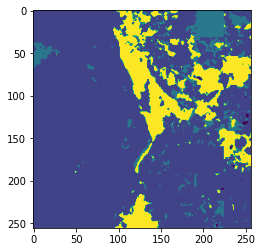

In [ ]:
plt.imshow(plt.imread(get_y_fn(fnames[59])))

In [ ]:
codes = np.array(['Otherland',
                  'Cropland', 
                  'Pastureland',
                  'Bare soil',
                  'Openwater',
                  'Forestland'])

In [ ]:
import albumentations
class AlbumentationsTransform(RandTransform):
    "A transform handler for multiple `Albumentation` transforms"
    split_idx,order=None,2
    def __init__(self, train_aug, valid_aug): store_attr()
    
    def before_call(self, b, split_idx):
        self.idx = split_idx
    
    def encodes(self, img: PILImage):
        if self.idx == 0:
            aug_img = self.train_aug(image=np.array(img))['image']
        else:
            aug_img = self.valid_aug(image=np.array(img))['image']
        return PILImage.create(aug_img)

def get_train_aug(): return albumentations.Compose([
            albumentations.RandomResizedCrop(224,224),
            albumentations.Transpose(p=0.5),
            albumentations.HorizontalFlip(p=0.5),
            albumentations.VerticalFlip(p=0.5),
            albumentations.ShiftScaleRotate(p=0.5),
            albumentations.HueSaturationValue(
                hue_shift_limit=0.2, 
                sat_shift_limit=0.2, 
                val_shift_limit=0.2, 
                p=0.5),
             albumentations.RandomBrightnessContrast(
                brightness_limit=(-0.1,0.1), 
                contrast_limit=(-0.1, 0.1), 
                p=0.5),
            albumentations.CoarseDropout(p=0.5),
            albumentations.Cutout(p=0.5)
])

def get_valid_aug(): return albumentations.Compose([
    albumentations.CenterCrop(224,224, p=1.),
    albumentations.Resize(224,224)
], p=1.)

In [ ]:
item_tfms = [Resize(224), AlbumentationsTransform(get_train_aug(), get_valid_aug())]

In [ ]:
'''
lcn = DataBlock(blocks=(ImageBlock, MaskBlock(codes)),
                get_items = get_image_files,
                get_y = get_y_fn,
                splitter = RandomSplitter(valid_pct=0.1),
                item_tfms = RandomResizedCrop(224, min_scale=0.35),
                batch_tfms = Normalize.from_stats(*imagenet_stats))
'''

lcn = DataBlock(blocks=(ImageBlock, MaskBlock(codes)),
                get_items = get_image_files,
                get_y = get_y_fn,
                splitter = RandomSplitter(valid_pct=0.1),
                item_tfms = item_tfms,
                batch_tfms = Normalize.from_stats(*imagenet_stats))

#lcn.summary(path_img)

In [ ]:
dls = lcn.dataloaders(source=path_img, path=path, bs=8)

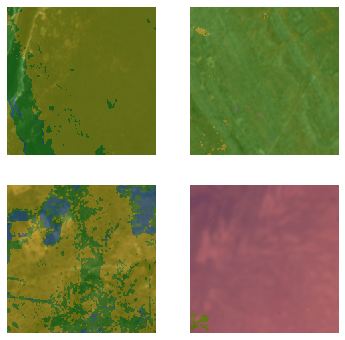

In [ ]:
dls.train.show_batch(max_n=4)

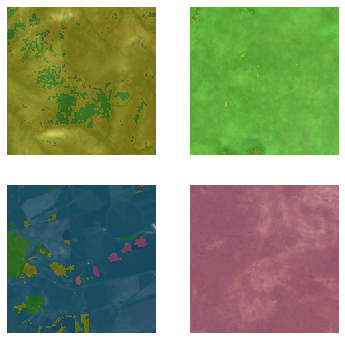

In [ ]:
dls.valid.show_batch(max_n=4)

In [ ]:
x,_ = dls.valid.one_batch()
print(x.shape)

(8, 3, 224, 224)


In [ ]:
x,_ = dls.train.one_batch()
print(x.shape)

(8, 3, 224, 224)


In [ ]:
def segm_acc(input, target) :
  target = target.squeeze(1)
  return (input.argmax(dim=1)==torch.tensor(target)).float().mean()

In [ ]:
#learn = unet_learner(dls, resnet50, metrics=segm_acc)
#learn = cnn_learner(dls, models.squeezenet1_1, metrics=segm_acc)
learn = unet_learner(dls, models.resnet50, metrics=segm_acc)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


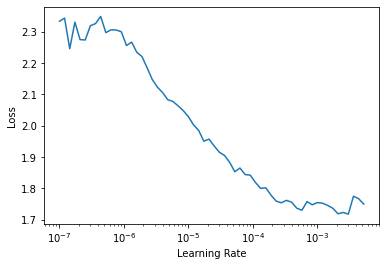

In [ ]:
#learn.loss_func = CrossEntropyLossFlat(axis = 1)
lr_min, lr_steep = learn.lr_find()

In [ ]:
lr_min, lr_steep

(0.0003019951749593019, 9.12010818865383e-07)

In [ ]:
#learn.fit_one_cycle(3, lr_max=0.002)
learn.fit_one_cycle(3, lr_max=slice(lr_steep, lr_min))

epoch,train_loss,valid_loss,segm_acc,time
0,1.248347,1.160370,0.533755,10:49
1,1.148475,1.128688,0.525076,10:22
2,1.029529,1.026945,0.576443,10:22


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until


2.511886486900039e-06 2.2908675418875646e-06


epoch,train_loss,valid_loss,segm_acc,time
0,0.999432,0.983474,0.588459,10:32
1,1.031189,0.998259,0.583886,10:32
2,1.036646,0.978955,0.586867,10:32
3,1.024760,0.977308,0.586284,10:32
4,1.016453,0.989989,0.583132,10:32
5,1.027598,0.939021,0.597488,10:32


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until


No improvement since epoch 0: early stopping


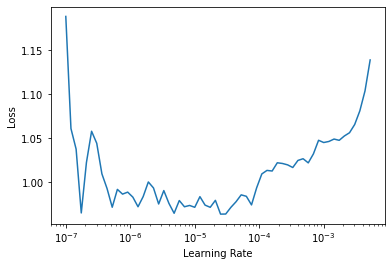

In [ ]:
learn.unfreeze()
lr_min, lr_steep = learn.lr_find()
print(lr_min, lr_steep)
learn.fit_one_cycle(n_epoch=50, lr_max=slice(lr_steep, lr_min), cbs=EarlyStoppingCallback(monitor='segm_acc', min_delta=0.1, patience=5))

In [ ]:
# save the model
learn.export('lcn_unet_resnet50_album_aug.pkl')
learn.save('lcn_unet_resnet50_album_aug_saved')

Path('drive/My Drive/landcovernet_final/models/lcn_unet_resnet50_album_aug_saved.pth')